<a href="https://colab.research.google.com/github/BenYavor/WGAN_Channel_Estimation-in-process-/blob/master/WGAN_Channel_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
#from Clustering_Equalgrps.equal_groups import EqualGroupsKMeans
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
print(M)

batch_size = 100

SNR = 7


16


## Training Parameter

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
# = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


#noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [4]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std


noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


# Models

In [5]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
  process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
  for line in process.stdout:
      print(line.decode().strip())
      
import sys, subprocess
IN_COLAB = 'google.colab' in sys.modules
colab_requirements = ['pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513']
if IN_COLAB:
  for i in colab_requirements:
    run_subprocess_command(i)

### load packages

In [6]:
# make visible the only one GPU
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [8]:
print(tf.__version__)

2.0.0-dev20190513


In [0]:
#TRAIN_BUF=60000
#BATCH_SIZE=512
#TEST_BUF=10000
#DIMS = (28,28,1)
#N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
#N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
#print(N_TRAIN_BATCHES)

In [0]:
####Datensets muessen theortisch die originale sein, also bei mir Rauschen und das Rauschen über den Kanal

# load dataset
#(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
#    "float32"
#) / 255.0
#test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
#train_dataset = (
#    tf.data.Dataset.from_tensor_slices(train_images)
#    .shuffle(TRAIN_BUF)
#    .batch(BATCH_SIZE)
#)
#test_dataset = (
#    tf.data.Dataset.from_tensor_slices(test_images)
#    .shuffle(TEST_BUF)
#    .batch(BATCH_SIZE)
#)

def creat_train_data(length):
  train_dataset=[]
  for i in range(length):
    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    train_dataset.append(real_channel(x,noise_std))
  return train_dataset

train_dataset = creat_train_data(100)

test_dataset = creat_train_data(100)


### Define the network as tf.keras.model object

In [0]:
#@tf.function
def train(real_data):
  gen_gradients, disc_gradients = compute_gradients(real_data)
  apply_gradients(gen_gradients, disc_gradients)

In [0]:
def compute_gradients(real_data):
  """ passes through the network and computes loss
  """
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    disc_loss, gen_loss = compute_loss(real_data)
  gen_gradients = gen_tape.gradient(gen_loss, w_generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, w_discriminator.trainable_variables)

  print("compute_gradients")

  return gen_gradients, disc_gradients

In [0]:
def compute_loss(real_data):
  """ passes through the network and computes loss
  """
        ### pass through network
        # generating noise from a uniform distribution
  ####Mein noise ist anders als hier
  gradient_penalty_weight = 10


  
  x_samp = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)
  #print(x_samp)
  # run noise through generator
  x_gen = w_generator(x_samp,training =True)     # x_gen zu fake_data
  # discriminate x and x_gen
  logits_x = w_discriminator(real_data)
  logits_x_gen = w_discriminator(x_gen)

  # gradient penalty
  d_regularizer = gradient_penalty(real_data, x_gen)
        ### losses
  disc_loss = (tf.reduce_mean(logits_x) - tf.reduce_mean(logits_x_gen)+ d_regularizer * gradient_penalty_weight)

        # losses of fake with label "1"
  gen_loss = tf.reduce_mean(logits_x_gen)
  return disc_loss, gen_loss



def apply_gradients(gen_gradients, disc_gradients):
  gen_optimizer.apply_gradients(zip(gen_gradients, w_generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, w_discriminator.trainable_variables))

def gradient_penalty(x, x_gen):
  epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
  x_hat = epsilon * x + (1 - epsilon) * x_gen
  with tf.GradientTape() as t:
      t.watch(x_hat)
      d_hat = w_discriminator(x_hat)
  gradients = t.gradient(d_hat, x_hat)
  ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
  d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
  #print("gradient_penalty")
  return d_regularizer



### Define the network architecture

## Changes
in dem vorherigen GAN modell hat der discriminator side_infomation erhalten, worin das original Rauschen enthalten war. Dies ist in dem WGAN paper anders gemacht worden.

In [0]:
N_Z = n


w_generator = keras.models.Sequential([
  tf.keras.layers.Input(shape=(n,)),
  tf.keras.layers.Dense(32,use_bias=True,  activation='relu'),
  tf.keras.layers.Dense(32,use_bias=True, activation='relu'),
  tf.keras.layers.Dense(n, use_bias= True, activation='sigmoid')
   ])

w_discriminator = keras.models.Sequential([
  tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((n,))),
  #model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid')
])



### Create Model

In [0]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.0001)#, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model
# model
#model = WGAN(
#    gen = w_generator,
#    disc = w_discriminator,
#    gen_optimizer = gen_optimizer,
#    disc_optimizer = disc_optimizer,
#    n_Z = N_Z,
gradient_penalty_weight = 10.0


### Train the model

In [0]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [0]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [18]:
n_epochs = 500
for epoch in range(n_epochs):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x_samp  = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  real_data = real_channel(x_samp, noise_std)
  train(real_data)
    # test on holdout
  loss = []

  loss.append(compute_loss(real_data))
  losses.loc[len(losses)] = np.mean(loss, axis=0)
  print(
       "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )  )
# plot_reconstruction(model)

compute_gradients
Epoch: 0 | disc_loss: 7.296729564666748 | gen_loss: 0.5035708546638489
compute_gradients
Epoch: 1 | disc_loss: 7.239821910858154 | gen_loss: 0.5041967034339905
compute_gradients
Epoch: 2 | disc_loss: 7.054571628570557 | gen_loss: 0.5047413110733032
compute_gradients
Epoch: 3 | disc_loss: 6.89886474609375 | gen_loss: 0.5053767561912537
compute_gradients
Epoch: 4 | disc_loss: 6.6467084884643555 | gen_loss: 0.5056905746459961
compute_gradients
Epoch: 5 | disc_loss: 6.61902379989624 | gen_loss: 0.5058331489562988
compute_gradients
Epoch: 6 | disc_loss: 6.489140033721924 | gen_loss: 0.5062851905822754
compute_gradients
Epoch: 7 | disc_loss: 6.474483013153076 | gen_loss: 0.5065643787384033
compute_gradients
Epoch: 8 | disc_loss: 6.4216508865356445 | gen_loss: 0.5070045590400696
compute_gradients
Epoch: 9 | disc_loss: 6.4001970291137695 | gen_loss: 0.5075452327728271
compute_gradients
Epoch: 10 | disc_loss: 6.216831684112549 | gen_loss: 0.5076703429222107
compute_gradients
E

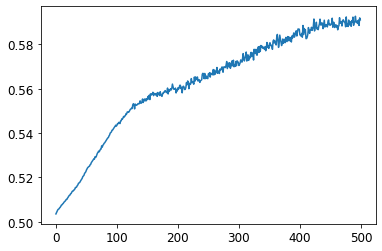

In [19]:
plt.plot(losses.gen_loss.values)


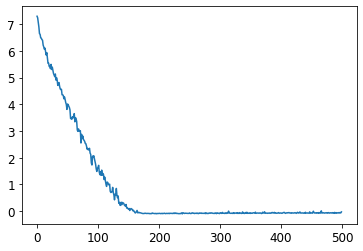

In [20]:
plt.plot(losses.disc_loss.values)


#### Encoder GAN Model

In [21]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
print(epsilon.shape)

(100, 1, 1, 1)


# GAN Training

In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = gan_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()



def Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = real_channel(code_word,noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


# AE training

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(n, activation=None),
            e2,
            EncOut,
            GenIn])
  return model


In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])
   return model

In [0]:
w_generator.trainable =False

In [26]:
#%%time
gan_decoder = get_gan_decoder(M)
gan_encoder = get_gan_encoder(M)

gan_AE = tf.keras.models.Sequential([gan_encoder,w_generator,gan_decoder])
data, test_data = random_sample(1000000), random_sample(1000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=400,steps_per_epoch=200, epochs=6)
#time_to_train_gan += time.time()-start
#tf.print ('Time for the training is {} sec,'.format( time.time()-start))
gan_AE.summary()  

Epoch 1/6
200/200 [==============================] - 318s 2s/step - loss: 2.2247 - accuracy: 0.2422
Epoch 2/6
200/200 [==============================] - 317s 2s/step - loss: 1.6494 - accuracy: 0.4948
Epoch 3/6
200/200 [==============================] - 317s 2s/step - loss: 1.3536 - accuracy: 0.6408
Epoch 4/6
200/200 [==============================] - 317s 2s/step - loss: 1.1087 - accuracy: 0.7658
Epoch 5/6
200/200 [==============================] - 317s 2s/step - loss: 0.8200 - accuracy: 0.8445
Epoch 6/6
200/200 [==============================] - 316s 2s/step - loss: 0.5232 - accuracy: 0.9359
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, None)              562       
_________________________________________________________________
sequential (Sequential)      (None, 2)                 1218      
________________________________________________

### Training MI

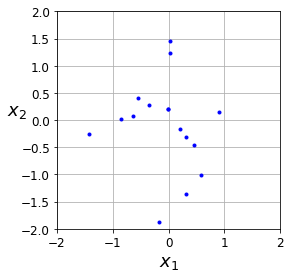

In [27]:
gan_encoder.trainable = False
gan_decoder.trainable = False

test_encoding(M,n)   


In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

#### decoder GAN Model

In [29]:
gan_bber_data = Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


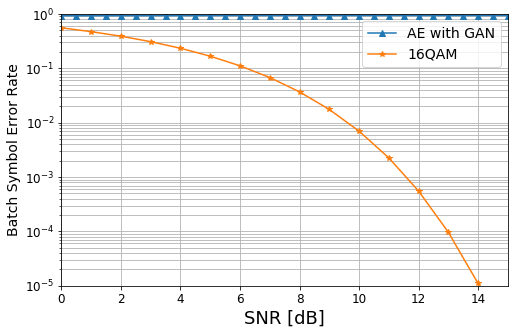

In [30]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with WGAN', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")

#print('time to train the AE Model with MI',time_to_train_mi)
#print('time to train the AE Model with GAN',time_to_train_gan)

In [31]:
print(range(11))

range(0, 11)
